In [14]:
import os
import gc

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

DATA_PATH = 'data'
OUT_PATH = 'data'

In [15]:
# Create the data directory if it doesn't exist
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Download sample data
!wget -O data/aqi.csv https://raw.githubusercontent.com/medAli-ai/Beijing-air-quality-prediction-internship/refs/heads/main/src/AirQualityData/airquality_data.csv


--2025-09-05 07:31:35--  https://raw.githubusercontent.com/medAli-ai/Beijing-air-quality-prediction-internship/refs/heads/main/src/AirQualityData/airquality_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31731212 (30M) [text/plain]
Saving to: ‘data/aqi.csv’

data/aqi.csv        100%[===================>]  30.26M  --.-KB/s    in 0.1s    

2025-09-05 07:31:35 (245 MB/s) - ‘data/aqi.csv’ saved [31731212/31731212]



In [16]:
import os
import pandas as pd

DATA_PATH = 'data'

# List files in the data directory
file_list = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) if f.endswith('.csv')]

# Read and concatenate the data
data_list = []
for file in file_list:
    data = pd.read_csv(file)
    data_list.append(data)

if data_list:
    data = pd.concat(data_list, axis=0)
    display(data.head())
else:
    print("No CSV files found in the data directory.")

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


In [17]:
data.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


In [18]:
data.isna().sum()


,0
No,0
year,0
month,0
day,0
hour,0
PM2.5,0
PM10,0
SO2,0
NO2,0
CO,0


<Axes: xlabel='PM2.5', ylabel='Count'>

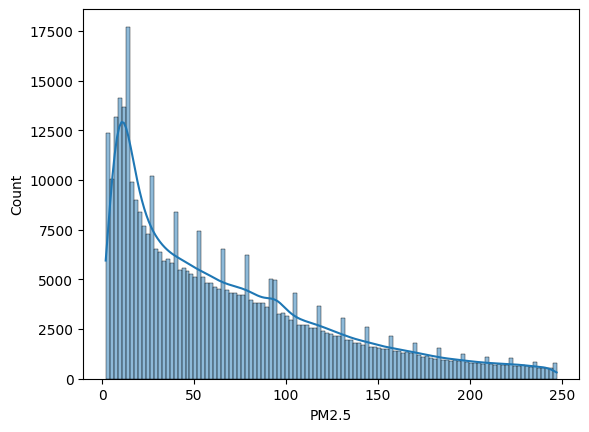

In [19]:
pm2_5 = data['PM2.5']
sns.histplot(pm2_5, kde=True)

In [20]:
q1 = data['PM2.5'].quantile(0.25)
q3 = data['PM2.5'].quantile(0.75)
iqr = q3 - q1
# Filter outlier observation and take their index
filtration = (data['PM2.5'] < q1 - 1.5 * iqr) | (data['PM2.5'] > q3 + 1.5 *iqr)
df_index1 = list(data.loc[filtration].index)
data = data.loc[~filtration]

In [21]:
data.shape


(393630, 18)

In [22]:
CAT_FEATURES = data.select_dtypes(include=['object']).columns.tolist()

for cat_col in CAT_FEATURES:
    encoder = LabelEncoder()
    data[cat_col] = encoder.fit_transform(data[cat_col])

data['wd'] = data['wd'].fillna(data['wd'].mode()[0])
assert data['wd'].isna().sum() == 0

del CAT_FEATURES
_ = gc.collect()

In [23]:
%%time
knn_imputer = KNNImputer(n_neighbors=5)
na_columns = data.loc[:, data.isnull().any()].columns.tolist()
num_cols = [col for col in na_columns if col != 'wd']

if num_cols:
    data[num_cols] = knn_imputer.fit_transform(data[na_cols])
else:
    print("No numerical columns with missing values to impute.")

No numerical columns with missing values to impute.
CPU times: user 6.83 ms, sys: 0 ns, total: 6.83 ms
Wall time: 6.97 ms


In [24]:
data.isna().sum()


,0
No,0
year,0
month,0
day,0
hour,0
PM2.5,0
PM10,0
SO2,0
NO2,0
CO,0


In [25]:
data.to_csv(f'{OUT_PATH}airquality_data.csv', index=False)


In [26]:
import os
import random
from tqdm.auto import tqdm
import time
import wandb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW

In [30]:
from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau,
OneCycleLR)
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

DIR = './'
if not os.path.exists(DIR):
    os.mkdir(DIR)

device=("cuda" if torch.cuda.is_available() else "cpu")
VERSION=11

In [32]:
data = pd.read_csv('dataairquality_data.csv')
FEATURES_COLUMNS = [col for col in data.columns if col not in ['No', 'year', 'month', 'day', 'hour']]

In [34]:
# !pip install pytorch-lightning

In [35]:
class CFG:
    apex=False
    debug=False
    kaggle = True
    print_freq=2000
    num_workers=1
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=60
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':5,
        'eta_min':1e-4,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3
    }
    batch_size=32 #64
    lr=1e-4
    weight_decay=1e-2
    gradient_accumulation_steps=1
    max_grad_norm=1000 # Gradient clipping to prevent exploding / vanishing gradient
    target_size=1
    num_layers=3
    input_size=len(FEATURES_COLUMNS)
    hidden_size=100
    seq_length=48 # 48h
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    target_col="PM2.5"
    model_name="lstm_network"
    group = 'lstm'
    train=True
    seed=42

if CFG.debug:
    CFG.epochs=2
    data=data.sample(n=10000, random_state=CFG.seed).reset_index(drop=True).fillna(method="ffill")

In [36]:
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [37]:
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

In [38]:
def get_score(y_true, y_pred):
    score = math.sqrt(mse(y_true, y_pred))
    return score

def init_logger(log_file=DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


In [39]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=45)

def rolling_window(data_df, window=1):

    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean().fillna(0)
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]

    return rolling_df

In [40]:

def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):

    sequences = []
    data_size = input_data.shape[0]
    for i in tqdm(range(data_size - sequence_length)):

        sequence = input_data[i: i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence[[col for col in sequence.columns if col not in ['No']]], label))

    return sequences

def diff_data(data_df, diff=1):

    diff_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour']]].diff(diff).fillna(0)
    diff_df.columns = [col+"_"+f"diff_{diff}" for col in diff_df.columns]

    return diff_df

In [41]:
train_diff = diff_data(train, diff=1)
train = pd.concat([train, train_diff], axis=1)

valid_diff = diff_data(valid, diff=1)
valid = pd.concat([valid, valid_diff], axis=1)

test_diff = diff_data(test, diff=1)
test = pd.concat([test, test_diff], axis=1)

FEATURES_COLUMNS = [col for col in train.columns if col not in ['No']]
CFG.input_size = len(FEATURES_COLUMNS)

In [42]:
%%time
train_sequence = create_sequences(train, CFG.target_col, CFG.seq_length)
valid_sequence = create_sequences(valid, CFG.target_col, CFG.seq_length)
test_sequence = create_sequences(test, CFG.target_col, CFG.seq_length)

  0%|          | 0/318792 [00:00<?, ?it/s]

  0%|          | 0/35379 [00:00<?, ?it/s]

  0%|          | 0/39315 [00:00<?, ?it/s]

CPU times: user 4min 58s, sys: 20.4 s, total: 5min 19s
Wall time: 5min 33s


In [44]:
#  Dataset
class AirQualityDataset(Dataset):

    def __init__(self, sequences):

        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):

        sequence, target = self.sequences[idx]

        return torch.tensor(sequence.to_numpy()).float(), torch.tensor(target).float()

In [45]:
train_dataset = AirQualityDataset(train_sequence)
sequence, label = train_dataset[0]
print(f'sequence shape: {sequence.shape}')
print(f'label shape: {label.shape}')

sequence shape: torch.Size([48, 28])
label shape: torch.Size([])


In [48]:
if CFG.kaggle:

    wandb_api = '53491ecfcad6c7cc4991c3af72f40f99294d70db'
    wandb.login(key=wandb_api)

else:

    wandb.login()

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="AIRQualityPrediction",
                 name=CFG.model_name,
                 config=class2dict(CFG),
                 group=CFG.group,
                 tags=[f'CFG.model_name_version{VERSION}'],
                 job_type="train")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kunaldp379 (kunaldp379-vesit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [77]:
class LSTM(nn.Module):

    def __init__(
                 self,
                 target_size=CFG.target_size,
                 input_size=CFG.input_size,
                 hidden_size=CFG.hidden_size,
                 num_layers=CFG.num_layers
                 ):

        super(LSTM, self).__init__()

        self.target_size = CFG.target_size
        self.num_layers = CFG.num_layers
        self.input_size = CFG.input_size
        self.hidden_size = CFG.hidden_size
        self.seq_length = CFG.seq_length

        self.lstm = nn.LSTM(
                            input_size=self.input_size, # Features of the sequence
                            hidden_size=self.hidden_size, # Hidden units for the lstm
                            num_layers=self.num_layers, # Number of layers
                            batch_first=True, # (batch, seq, features)
                            dropout=0.2,
                            bidirectional=True
                           )

        self.fc = nn.Linear(self.hidden_size * 2, self.target_size) # Multiply hidden_size by 2 for bidirectional LSTM

    def forward(self, x):

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x)

        # Use the output from the last time step
        out = self.fc(ula[:, -1, :])

        return out

In [78]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [79]:
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [80]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (sequences, targets) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(sequences)
                loss = criterion(y_preds.squeeze(1), targets)
        else:
            y_preds = model(sequences)
            loss = criterion(y_preds.squeeze(1), targets)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader),
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        if fold:

            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
        else:

            wandb.log({"loss": losses.val,
                       "lr": scheduler.get_last_lr()[0]})

    return losses.avg


In [81]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    targets_list = []
    start = end = time.time()
    for step, (sequences, targets) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(sequences)
        preds.append(y_preds.detach().to('cpu').numpy())
        targets_list.append(targets.detach().to('cpu').numpy())
        loss = criterion(y_preds.squeeze(1), targets)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    targets = np.concatenate(targets_list)
    return losses.avg, predictions, targets

In [82]:
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    forcasts = []
    targets_list = []
    for i, (sequences, targets) in enumerate(tk0):
        sequences = sequences.to(device).float()
        targets = targets.to(device).float()
        avg_forcasts = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(sequences)
            avg_forcasts.append(y_preds.detach().to("cpu").numpy())
        avg_forcasts = np.mean(avg_forcasts, axis=0)
        forcasts.append(avg_forcasts)
        targets_list.append(targets.detach().to("cpu").numpy())
    forcasts = np.concatenate(forcasts)
    targets = np.concatenate(targets_list)
    return forcasts, targets

In [83]:
seed_torch(seed=45)
train_dataset = AirQualityDataset(train_sequence)

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False, # Time series data
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)


valid_dataset = AirQualityDataset(valid_sequence)

valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


test_dataset = AirQualityDataset(test_sequence)

test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [84]:
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

In [85]:
model = LSTM()
model.to(device)
optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = get_scheduler(optimizer)

In [86]:
criterion = nn.MSELoss()
best_loss = np.inf

In [87]:
for epoch in range(CFG.epochs):

    start_time = time.time()


    # train
    avg_loss = train_fn(None, train_loader, model, criterion, optimizer, epoch, scheduler, device)

    # eval
    avg_val_loss, valid_preds, valid_targets = valid_fn(valid_loader, model, criterion, device)

    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    # scoring
    score = get_score(valid_targets, valid_preds)
    elapsed = time.time() - start_time
    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
    wandb.log({f" epoch": epoch+1,
               f" avg_train_loss": avg_loss,
               f" avg_val_loss": avg_val_loss,
               f" score": score
              })
    # Save best weights
    if avg_val_loss < best_loss:
        LOGGER.info(f"Validation loss Improved ({best_loss} ---> {avg_val_loss})")
        best_loss = avg_val_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict(),
                    'preds_loss': valid_preds,
                    'targets': valid_targets},
                    DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth')

Epoch: [1][0/9962] Elapsed 0m 1s (remain 213m 25s) Loss: 5656.9854(5656.9854) Grad: 210.2925 LR: 0.000100  
Epoch: [1][2000/9962] Elapsed 0m 25s (remain 1m 41s) Loss: 6175.1895(4915.2805) Grad: 1823.9846 LR: 0.000100  
Epoch: [1][4000/9962] Elapsed 0m 47s (remain 1m 11s) Loss: 148.4361(3934.7915) Grad: 5528.0356 LR: 0.000100  
Epoch: [1][6000/9962] Elapsed 1m 9s (remain 0m 45s) Loss: 1128.6165(3418.1033) Grad: 7003.2710 LR: 0.000100  
Epoch: [1][8000/9962] Elapsed 1m 31s (remain 0m 22s) Loss: 186.8292(2975.9883) Grad: 14137.1943 LR: 0.000100  
Epoch: [1][9961/9962] Elapsed 1m 53s (remain 0m 0s) Loss: 7354.4946(2629.8255) Grad: 16172.0010 LR: 0.000100  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 59s) Loss: 153.4648(153.4648) 
EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 48.6832(1219.2465) 


Epoch 1 - avg_train_loss: 2629.8255  avg_val_loss: 1219.2465  time: 123s
INFO:__main__:Epoch 1 - avg_train_loss: 2629.8255  avg_val_loss: 1219.2465  time: 123s
Epoch 1 - Score: 34.9177
INFO:__main__:Epoch 1 - Score: 34.9177
Validation loss Improved (inf ---> 1219.2464765407835)
INFO:__main__:Validation loss Improved (inf ---> 1219.2464765407835)
Epoch 1 - Save Best Loss: 1219.2465 Model
INFO:__main__:Epoch 1 - Save Best Loss: 1219.2465 Model


Epoch: [2][0/9962] Elapsed 0m 0s (remain 27m 52s) Loss: 511.7159(511.7159) Grad: 20846.5371 LR: 0.000094  
Epoch: [2][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 946.5656(1125.1508) Grad: 36624.3828 LR: 0.000094  
Epoch: [2][4000/9962] Elapsed 0m 47s (remain 1m 10s) Loss: 101.5969(1006.1750) Grad: 13439.9971 LR: 0.000094  
Epoch: [2][6000/9962] Elapsed 1m 9s (remain 0m 46s) Loss: 298.9599(955.6745) Grad: 37044.4883 LR: 0.000094  
Epoch: [2][8000/9962] Elapsed 1m 30s (remain 0m 22s) Loss: 154.3270(889.6027) Grad: 19787.5332 LR: 0.000094  
Epoch: [2][9961/9962] Elapsed 1m 52s (remain 0m 0s) Loss: 3628.7317(825.4122) Grad: 12875.2520 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 36.9315(36.9315) 


Epoch 2 - avg_train_loss: 825.4122  avg_val_loss: 606.8996  time: 122s


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 45.2196(606.8996) 


INFO:__main__:Epoch 2 - avg_train_loss: 825.4122  avg_val_loss: 606.8996  time: 122s
Epoch 2 - Score: 24.6353
INFO:__main__:Epoch 2 - Score: 24.6353
Validation loss Improved (1219.2464765407835 ---> 606.899615246673)
INFO:__main__:Validation loss Improved (1219.2464765407835 ---> 606.899615246673)
Epoch 2 - Save Best Loss: 606.8996 Model
INFO:__main__:Epoch 2 - Save Best Loss: 606.8996 Model


Epoch: [3][0/9962] Elapsed 0m 0s (remain 27m 15s) Loss: 424.7667(424.7667) Grad: 85591.8281 LR: 0.000078  
Epoch: [3][2000/9962] Elapsed 0m 21s (remain 1m 27s) Loss: 464.8719(573.2482) Grad: 56649.3750 LR: 0.000078  
Epoch: [3][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 75.2543(532.5686) Grad: 34296.4727 LR: 0.000078  
Epoch: [3][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 284.8715(523.6137) Grad: 47023.8984 LR: 0.000078  
Epoch: [3][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 101.9580(503.8511) Grad: 11173.4785 LR: 0.000078  
Epoch: [3][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 2159.3735(481.8059) Grad: 12005.3252 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 70.3296(70.3296) 
EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 60.8114(440.0348) 


Epoch 3 - avg_train_loss: 481.8059  avg_val_loss: 440.0348  time: 119s
INFO:__main__:Epoch 3 - avg_train_loss: 481.8059  avg_val_loss: 440.0348  time: 119s
Epoch 3 - Score: 20.9770
INFO:__main__:Epoch 3 - Score: 20.9770
Validation loss Improved (606.899615246673 ---> 440.0347788273309)
INFO:__main__:Validation loss Improved (606.899615246673 ---> 440.0347788273309)
Epoch 3 - Save Best Loss: 440.0348 Model
INFO:__main__:Epoch 3 - Save Best Loss: 440.0348 Model


Epoch: [4][0/9962] Elapsed 0m 0s (remain 47m 14s) Loss: 421.1480(421.1480) Grad: 34357.8359 LR: 0.000055  
Epoch: [4][2000/9962] Elapsed 0m 21s (remain 1m 26s) Loss: 244.9128(419.6338) Grad: 47044.1133 LR: 0.000055  
Epoch: [4][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 44.9790(395.4254) Grad: 11973.9727 LR: 0.000055  
Epoch: [4][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 215.5237(393.8787) Grad: 35597.7070 LR: 0.000055  
Epoch: [4][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 105.6019(383.9347) Grad: 13484.5156 LR: 0.000055  
Epoch: [4][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 1484.2308(373.0904) Grad: 12123.3359 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 54s) Loss: 67.5464(67.5464) 


Epoch 4 - avg_train_loss: 373.0904  avg_val_loss: 379.9471  time: 118s
INFO:__main__:Epoch 4 - avg_train_loss: 373.0904  avg_val_loss: 379.9471  time: 118s
Epoch 4 - Score: 19.4922
INFO:__main__:Epoch 4 - Score: 19.4922
Validation loss Improved (440.0347788273309 ---> 379.94710067274167)
INFO:__main__:Validation loss Improved (440.0347788273309 ---> 379.94710067274167)
Epoch 4 - Save Best Loss: 379.9471 Model
INFO:__main__:Epoch 4 - Save Best Loss: 379.9471 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 37.4910(379.9471) 
Epoch: [5][0/9962] Elapsed 0m 0s (remain 20m 0s) Loss: 449.8480(449.8480) Grad: 75497.9688 LR: 0.000033  
Epoch: [5][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 258.3904(359.8701) Grad: 38766.1758 LR: 0.000033  
Epoch: [5][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 59.9043(342.3772) Grad: 6526.3247 LR: 0.000033  
Epoch: [5][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 274.7035(342.1500) Grad: 62951.6758 LR: 0.000033  
Epoch: [5][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 60.1650(336.2523) Grad: 21696.7285 LR: 0.000033  
Epoch: [5][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 1186.4098(329.5024) Grad: 26646.2715 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 57s) Loss: 61.2138(61.2138) 


Epoch 5 - avg_train_loss: 329.5024  avg_val_loss: 321.9769  time: 118s
INFO:__main__:Epoch 5 - avg_train_loss: 329.5024  avg_val_loss: 321.9769  time: 118s
Epoch 5 - Score: 17.9437
INFO:__main__:Epoch 5 - Score: 17.9437
Validation loss Improved (379.94710067274167 ---> 321.9768981392318)
INFO:__main__:Validation loss Improved (379.94710067274167 ---> 321.9768981392318)
Epoch 5 - Save Best Loss: 321.9769 Model
INFO:__main__:Epoch 5 - Save Best Loss: 321.9769 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 38.2524(321.9769) 
Epoch: [6][0/9962] Elapsed 0m 0s (remain 19m 35s) Loss: 399.5161(399.5161) Grad: 36280.3711 LR: 0.000016  
Epoch: [6][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 208.9684(335.5108) Grad: 36253.8711 LR: 0.000016  
Epoch: [6][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 48.9263(319.0295) Grad: 10772.6299 LR: 0.000016  
Epoch: [6][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 207.7551(319.0454) Grad: 71791.1172 LR: 0.000016  
Epoch: [6][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 106.2784(314.2342) Grad: 15948.1797 LR: 0.000016  
Epoch: [6][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 985.6579(309.3110) Grad: 14910.9795 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 56s) Loss: 57.3465(57.3465) 


Epoch 6 - avg_train_loss: 309.3110  avg_val_loss: 294.9826  time: 117s
INFO:__main__:Epoch 6 - avg_train_loss: 309.3110  avg_val_loss: 294.9826  time: 117s
Epoch 6 - Score: 17.1751
INFO:__main__:Epoch 6 - Score: 17.1751
Validation loss Improved (321.9768981392318 ---> 294.98257762428364)
INFO:__main__:Validation loss Improved (321.9768981392318 ---> 294.98257762428364)
Epoch 6 - Save Best Loss: 294.9826 Model
INFO:__main__:Epoch 6 - Save Best Loss: 294.9826 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 54.7352(294.9826) 
Epoch: [7][0/9962] Elapsed 0m 0s (remain 20m 3s) Loss: 378.1016(378.1016) Grad: 36236.1016 LR: 0.000010  
Epoch: [7][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 247.0904(322.8865) Grad: 25329.5039 LR: 0.000010  
Epoch: [7][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 46.4329(307.8991) Grad: 18031.7246 LR: 0.000010  
Epoch: [7][6000/9962] Elapsed 1m 5s (remain 0m 42s) Loss: 240.2993(307.8099) Grad: 63950.0195 LR: 0.000010  
Epoch: [7][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 75.4484(303.6785) Grad: 7492.4004 LR: 0.000010  
Epoch: [7][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 904.0719(299.6950) Grad: 10106.7871 LR: 0.000010  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 58s) Loss: 52.2114(52.2114) 


Epoch 7 - avg_train_loss: 299.6950  avg_val_loss: 286.4679  time: 117s
INFO:__main__:Epoch 7 - avg_train_loss: 299.6950  avg_val_loss: 286.4679  time: 117s
Epoch 7 - Score: 16.9254
INFO:__main__:Epoch 7 - Score: 16.9254
Validation loss Improved (294.98257762428364 ---> 286.4679043993921)
INFO:__main__:Validation loss Improved (294.98257762428364 ---> 286.4679043993921)
Epoch 7 - Save Best Loss: 286.4679 Model
INFO:__main__:Epoch 7 - Save Best Loss: 286.4679 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 57.0226(286.4679) 
Epoch: [8][0/9962] Elapsed 0m 0s (remain 20m 8s) Loss: 404.5624(404.5624) Grad: 29752.8984 LR: 0.000016  
Epoch: [8][2000/9962] Elapsed 0m 21s (remain 1m 24s) Loss: 163.6981(315.4834) Grad: 36679.0508 LR: 0.000016  
Epoch: [8][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 68.7076(301.3204) Grad: 19279.7070 LR: 0.000016  
Epoch: [8][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 234.2286(301.0180) Grad: 53792.7578 LR: 0.000016  
Epoch: [8][8000/9962] Elapsed 1m 25s (remain 0m 21s) Loss: 108.6836(296.9458) Grad: 9971.4785 LR: 0.000016  
Epoch: [8][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 788.6147(293.3844) Grad: 7108.8999 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 85.8878(85.8878) 


Epoch 8 - avg_train_loss: 293.3844  avg_val_loss: 278.4240  time: 117s
INFO:__main__:Epoch 8 - avg_train_loss: 293.3844  avg_val_loss: 278.4240  time: 117s
Epoch 8 - Score: 16.6860
INFO:__main__:Epoch 8 - Score: 16.6860
Validation loss Improved (286.4679043993921 ---> 278.4240221006146)
INFO:__main__:Validation loss Improved (286.4679043993921 ---> 278.4240221006146)
Epoch 8 - Save Best Loss: 278.4240 Model
INFO:__main__:Epoch 8 - Save Best Loss: 278.4240 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 49.2728(278.4240) 
Epoch: [9][0/9962] Elapsed 0m 0s (remain 19m 55s) Loss: 377.3169(377.3169) Grad: 31865.6738 LR: 0.000033  
Epoch: [9][2000/9962] Elapsed 0m 21s (remain 1m 23s) Loss: 201.2166(310.8420) Grad: 24349.9941 LR: 0.000033  
Epoch: [9][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 55.5290(296.8723) Grad: 6177.5332 LR: 0.000033  
Epoch: [9][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 229.3291(294.7649) Grad: 28870.0879 LR: 0.000033  
Epoch: [9][8000/9962] Elapsed 1m 25s (remain 0m 21s) Loss: 107.6108(289.4940) Grad: 11592.7324 LR: 0.000033  
Epoch: [9][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 610.7645(285.6060) Grad: 37170.4062 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 86.7199(86.7199) 


Epoch 9 - avg_train_loss: 285.6060  avg_val_loss: 269.4160  time: 116s


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 43.6785(269.4160) 


INFO:__main__:Epoch 9 - avg_train_loss: 285.6060  avg_val_loss: 269.4160  time: 116s
Epoch 9 - Score: 16.4139
INFO:__main__:Epoch 9 - Score: 16.4139
Validation loss Improved (278.4240221006146 ---> 269.4159873949032)
INFO:__main__:Validation loss Improved (278.4240221006146 ---> 269.4159873949032)
Epoch 9 - Save Best Loss: 269.4160 Model
INFO:__main__:Epoch 9 - Save Best Loss: 269.4160 Model


Epoch: [10][0/9962] Elapsed 0m 0s (remain 28m 18s) Loss: 322.2344(322.2344) Grad: 21019.9707 LR: 0.000055  
Epoch: [10][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 251.5100(303.2447) Grad: 63701.4961 LR: 0.000055  
Epoch: [10][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 66.6319(289.6571) Grad: 19535.1914 LR: 0.000055  
Epoch: [10][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 215.8170(287.4294) Grad: 21276.4746 LR: 0.000055  
Epoch: [10][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 105.4040(282.0599) Grad: 8604.4180 LR: 0.000055  
Epoch: [10][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 405.1321(278.1403) Grad: 37129.8359 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 107.8675(107.8675) 


Epoch 10 - avg_train_loss: 278.1403  avg_val_loss: 268.7436  time: 117s
INFO:__main__:Epoch 10 - avg_train_loss: 278.1403  avg_val_loss: 268.7436  time: 117s
Epoch 10 - Score: 16.3934
INFO:__main__:Epoch 10 - Score: 16.3934
Validation loss Improved (269.4159873949032 ---> 268.74358657804135)
INFO:__main__:Validation loss Improved (269.4159873949032 ---> 268.74358657804135)
Epoch 10 - Save Best Loss: 268.7436 Model
INFO:__main__:Epoch 10 - Save Best Loss: 268.7436 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 45.2987(268.7436) 
Epoch: [11][0/9962] Elapsed 0m 0s (remain 19m 39s) Loss: 368.8570(368.8570) Grad: 60625.7500 LR: 0.000078  
Epoch: [11][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 227.5713(294.8991) Grad: 52678.1406 LR: 0.000078  
Epoch: [11][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 74.1503(283.5179) Grad: 48240.0781 LR: 0.000078  
Epoch: [11][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 214.3028(282.2789) Grad: 31938.5234 LR: 0.000078  
Epoch: [11][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 84.4178(277.5592) Grad: 16419.9902 LR: 0.000078  
Epoch: [11][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 291.6483(274.7644) Grad: 29370.1875 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 49s) Loss: 67.6181(67.6181) 


Epoch 11 - avg_train_loss: 274.7644  avg_val_loss: 293.2129  time: 117s
INFO:__main__:Epoch 11 - avg_train_loss: 274.7644  avg_val_loss: 293.2129  time: 117s
Epoch 11 - Score: 17.1235
INFO:__main__:Epoch 11 - Score: 17.1235


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 46.9121(293.2129) 
Epoch: [12][0/9962] Elapsed 0m 0s (remain 19m 57s) Loss: 384.2145(384.2145) Grad: 28482.0938 LR: 0.000094  
Epoch: [12][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 181.1992(297.2145) Grad: 38346.6758 LR: 0.000094  
Epoch: [12][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 62.9671(283.3398) Grad: 41840.0625 LR: 0.000094  
Epoch: [12][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 178.7084(281.5097) Grad: 26744.6270 LR: 0.000094  
Epoch: [12][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 107.6851(277.1274) Grad: 23448.1367 LR: 0.000094  
Epoch: [12][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 296.5312(274.4387) Grad: 41468.4141 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 58s) Loss: 76.0872(76.0872) 


Epoch 12 - avg_train_loss: 274.4387  avg_val_loss: 277.4113  time: 118s
INFO:__main__:Epoch 12 - avg_train_loss: 274.4387  avg_val_loss: 277.4113  time: 118s
Epoch 12 - Score: 16.6557
INFO:__main__:Epoch 12 - Score: 16.6557


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 41.5312(277.4113) 
Epoch: [13][0/9962] Elapsed 0m 0s (remain 19m 39s) Loss: 396.8258(396.8258) Grad: 49186.0273 LR: 0.000100  
Epoch: [13][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 244.9230(294.0877) Grad: 49001.1016 LR: 0.000100  
Epoch: [13][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 63.0046(280.7159) Grad: 25529.5664 LR: 0.000100  
Epoch: [13][6000/9962] Elapsed 1m 6s (remain 0m 44s) Loss: 189.8179(278.8758) Grad: 24121.3340 LR: 0.000100  
Epoch: [13][8000/9962] Elapsed 1m 29s (remain 0m 21s) Loss: 86.4525(274.0445) Grad: 29849.4434 LR: 0.000100  
Epoch: [13][9961/9962] Elapsed 1m 50s (remain 0m 0s) Loss: 304.2806(271.5503) Grad: 30358.7109 LR: 0.000100  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 54s) Loss: 36.1202(36.1202) 


Epoch 13 - avg_train_loss: 271.5503  avg_val_loss: 283.4588  time: 120s
INFO:__main__:Epoch 13 - avg_train_loss: 271.5503  avg_val_loss: 283.4588  time: 120s
Epoch 13 - Score: 16.8362
INFO:__main__:Epoch 13 - Score: 16.8362


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 39.3817(283.4588) 
Epoch: [14][0/9962] Elapsed 0m 0s (remain 22m 5s) Loss: 452.6293(452.6293) Grad: 61894.8008 LR: 0.000094  
Epoch: [14][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 247.2276(289.4781) Grad: 81677.4922 LR: 0.000094  
Epoch: [14][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 61.1607(276.8408) Grad: 19250.3965 LR: 0.000094  
Epoch: [14][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 216.2943(275.2890) Grad: 43285.8906 LR: 0.000094  
Epoch: [14][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 99.3464(270.1465) Grad: 18220.4004 LR: 0.000094  
Epoch: [14][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 246.0111(267.8874) Grad: 34649.5664 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 40.3096(40.3096) 


Epoch 14 - avg_train_loss: 267.8874  avg_val_loss: 303.3944  time: 117s
INFO:__main__:Epoch 14 - avg_train_loss: 267.8874  avg_val_loss: 303.3944  time: 117s
Epoch 14 - Score: 17.4182
INFO:__main__:Epoch 14 - Score: 17.4182


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 47.6482(303.3944) 
Epoch: [15][0/9962] Elapsed 0m 0s (remain 19m 57s) Loss: 374.7902(374.7902) Grad: 35385.9883 LR: 0.000078  
Epoch: [15][2000/9962] Elapsed 0m 20s (remain 1m 23s) Loss: 193.1163(280.6268) Grad: 31567.3945 LR: 0.000078  
Epoch: [15][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 72.7986(270.3928) Grad: 29798.4023 LR: 0.000078  
Epoch: [15][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 183.2983(269.1020) Grad: 25668.1484 LR: 0.000078  
Epoch: [15][8000/9962] Elapsed 1m 25s (remain 0m 21s) Loss: 98.3291(264.7194) Grad: 11593.1670 LR: 0.000078  
Epoch: [15][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 222.6065(262.6949) Grad: 15676.2305 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 50.5445(50.5445) 
EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 41.1560(293.4819) 


Epoch 15 - avg_train_loss: 262.6949  avg_val_loss: 293.4819  time: 117s
INFO:__main__:Epoch 15 - avg_train_loss: 262.6949  avg_val_loss: 293.4819  time: 117s
Epoch 15 - Score: 17.1313
INFO:__main__:Epoch 15 - Score: 17.1313


Epoch: [16][0/9962] Elapsed 0m 0s (remain 28m 56s) Loss: 409.8348(409.8348) Grad: 18201.4746 LR: 0.000055  
Epoch: [16][2000/9962] Elapsed 0m 21s (remain 1m 26s) Loss: 222.9459(275.0835) Grad: 48921.9961 LR: 0.000055  
Epoch: [16][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 44.8652(264.0687) Grad: 8674.7793 LR: 0.000055  
Epoch: [16][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 150.6728(262.9629) Grad: 23813.7402 LR: 0.000055  
Epoch: [16][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 104.7726(258.3559) Grad: 12678.4561 LR: 0.000055  
Epoch: [16][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 228.9546(256.3211) Grad: 42511.1797 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 54s) Loss: 51.6461(51.6461) 


Epoch 16 - avg_train_loss: 256.3211  avg_val_loss: 275.2476  time: 117s
INFO:__main__:Epoch 16 - avg_train_loss: 256.3211  avg_val_loss: 275.2476  time: 117s
Epoch 16 - Score: 16.5906
INFO:__main__:Epoch 16 - Score: 16.5906


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 34.2561(275.2476) 
Epoch: [17][0/9962] Elapsed 0m 0s (remain 20m 11s) Loss: 400.7795(400.7795) Grad: 63264.0664 LR: 0.000033  
Epoch: [17][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 176.1423(271.5925) Grad: 42345.6289 LR: 0.000033  
Epoch: [17][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 40.1773(260.6403) Grad: 12124.6602 LR: 0.000033  
Epoch: [17][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 211.5567(259.3391) Grad: 61565.9414 LR: 0.000033  
Epoch: [17][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 98.2653(254.8370) Grad: 13065.6016 LR: 0.000033  
Epoch: [17][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 216.7945(252.6895) Grad: 24730.9688 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 31s) Loss: 39.3207(39.3207) 


Epoch 17 - avg_train_loss: 252.6895  avg_val_loss: 257.7373  time: 118s
INFO:__main__:Epoch 17 - avg_train_loss: 252.6895  avg_val_loss: 257.7373  time: 118s
Epoch 17 - Score: 16.0542
INFO:__main__:Epoch 17 - Score: 16.0542
Validation loss Improved (268.74358657804135 ---> 257.73732059377085)
INFO:__main__:Validation loss Improved (268.74358657804135 ---> 257.73732059377085)
Epoch 17 - Save Best Loss: 257.7373 Model
INFO:__main__:Epoch 17 - Save Best Loss: 257.7373 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 29.5194(257.7373) 
Epoch: [18][0/9962] Elapsed 0m 0s (remain 19m 25s) Loss: 341.0950(341.0950) Grad: 29259.4863 LR: 0.000016  
Epoch: [18][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 208.6540(270.8592) Grad: 58235.2617 LR: 0.000016  
Epoch: [18][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 45.9441(259.0616) Grad: 10070.6436 LR: 0.000016  
Epoch: [18][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 184.3422(257.0322) Grad: 35987.2812 LR: 0.000016  
Epoch: [18][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 99.2206(252.5542) Grad: 24424.7949 LR: 0.000016  
Epoch: [18][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 214.0173(250.4417) Grad: 31587.6426 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 52s) Loss: 53.0147(53.0147) 


Epoch 18 - avg_train_loss: 250.4417  avg_val_loss: 250.1302  time: 117s
INFO:__main__:Epoch 18 - avg_train_loss: 250.4417  avg_val_loss: 250.1302  time: 117s
Epoch 18 - Score: 15.8155
INFO:__main__:Epoch 18 - Score: 15.8155
Validation loss Improved (257.73732059377085 ---> 250.1302014609156)
INFO:__main__:Validation loss Improved (257.73732059377085 ---> 250.1302014609156)
Epoch 18 - Save Best Loss: 250.1302 Model
INFO:__main__:Epoch 18 - Save Best Loss: 250.1302 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 31.2015(250.1302) 
Epoch: [19][0/9962] Elapsed 0m 0s (remain 19m 48s) Loss: 345.9583(345.9583) Grad: 17192.8555 LR: 0.000010  
Epoch: [19][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 197.6937(268.8811) Grad: 37380.9219 LR: 0.000010  
Epoch: [19][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 36.8855(257.0997) Grad: 10874.0078 LR: 0.000010  
Epoch: [19][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 166.3068(255.4985) Grad: 41514.0547 LR: 0.000010  
Epoch: [19][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 87.5482(250.8758) Grad: 12975.5928 LR: 0.000010  
Epoch: [19][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 222.4364(248.8603) Grad: 50894.6289 LR: 0.000010  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 51.3387(51.3387) 


Epoch 19 - avg_train_loss: 248.8603  avg_val_loss: 249.1079  time: 117s
INFO:__main__:Epoch 19 - avg_train_loss: 248.8603  avg_val_loss: 249.1079  time: 117s
Epoch 19 - Score: 15.7832
INFO:__main__:Epoch 19 - Score: 15.7832
Validation loss Improved (250.1302014609156 ---> 249.10790410485637)
INFO:__main__:Validation loss Improved (250.1302014609156 ---> 249.10790410485637)
Epoch 19 - Save Best Loss: 249.1079 Model
INFO:__main__:Epoch 19 - Save Best Loss: 249.1079 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 30.5616(249.1079) 
Epoch: [20][0/9962] Elapsed 0m 0s (remain 22m 2s) Loss: 346.3955(346.3955) Grad: 31086.7930 LR: 0.000016  
Epoch: [20][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 181.1139(266.9569) Grad: 50959.9141 LR: 0.000016  
Epoch: [20][4000/9962] Elapsed 0m 42s (remain 1m 4s) Loss: 38.3921(255.8670) Grad: 5417.5483 LR: 0.000016  
Epoch: [20][6000/9962] Elapsed 1m 5s (remain 0m 42s) Loss: 179.3343(254.4671) Grad: 44163.9570 LR: 0.000016  
Epoch: [20][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 111.5635(249.9995) Grad: 16966.7188 LR: 0.000016  
Epoch: [20][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 233.8273(247.7515) Grad: 51575.0156 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 56s) Loss: 59.1487(59.1487) 


Epoch 20 - avg_train_loss: 247.7515  avg_val_loss: 248.1315  time: 117s
INFO:__main__:Epoch 20 - avg_train_loss: 247.7515  avg_val_loss: 248.1315  time: 117s
Epoch 20 - Score: 15.7522
INFO:__main__:Epoch 20 - Score: 15.7522
Validation loss Improved (249.10790410485637 ---> 248.13147446234436)
INFO:__main__:Validation loss Improved (249.10790410485637 ---> 248.13147446234436)
Epoch 20 - Save Best Loss: 248.1315 Model
INFO:__main__:Epoch 20 - Save Best Loss: 248.1315 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 29.0144(248.1315) 
Epoch: [21][0/9962] Elapsed 0m 0s (remain 19m 33s) Loss: 370.0313(370.0313) Grad: 32084.1113 LR: 0.000033  
Epoch: [21][2000/9962] Elapsed 0m 21s (remain 1m 23s) Loss: 189.4337(266.5282) Grad: 45032.6562 LR: 0.000033  
Epoch: [21][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 43.7890(256.0675) Grad: 6469.2227 LR: 0.000033  
Epoch: [21][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 222.0166(254.7364) Grad: 90882.4609 LR: 0.000033  
Epoch: [21][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 102.3033(250.6295) Grad: 14112.9590 LR: 0.000033  
Epoch: [21][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 232.6132(248.6790) Grad: 58765.4375 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 52s) Loss: 31.5030(31.5030) 
EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 29.6177(244.6768) 


Epoch 21 - avg_train_loss: 248.6790  avg_val_loss: 244.6768  time: 116s
INFO:__main__:Epoch 21 - avg_train_loss: 248.6790  avg_val_loss: 244.6768  time: 116s
Epoch 21 - Score: 15.6421
INFO:__main__:Epoch 21 - Score: 15.6421
Validation loss Improved (248.13147446234436 ---> 244.67675608343797)
INFO:__main__:Validation loss Improved (248.13147446234436 ---> 244.67675608343797)
Epoch 21 - Save Best Loss: 244.6768 Model
INFO:__main__:Epoch 21 - Save Best Loss: 244.6768 Model


Epoch: [22][0/9962] Elapsed 0m 0s (remain 26m 36s) Loss: 400.1794(400.1794) Grad: 24292.7598 LR: 0.000055  
Epoch: [22][2000/9962] Elapsed 0m 20s (remain 1m 23s) Loss: 148.5541(269.1337) Grad: 46183.3047 LR: 0.000055  
Epoch: [22][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 50.1259(257.6707) Grad: 30199.9668 LR: 0.000055  
Epoch: [22][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 234.7740(256.6316) Grad: 47007.7930 LR: 0.000055  
Epoch: [22][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 112.7950(252.1375) Grad: 21941.5039 LR: 0.000055  
Epoch: [22][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 264.8651(250.3413) Grad: 68855.6719 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 14s) Loss: 37.7947(37.7947) 


Epoch 22 - avg_train_loss: 250.3413  avg_val_loss: 246.1242  time: 116s
INFO:__main__:Epoch 22 - avg_train_loss: 250.3413  avg_val_loss: 246.1242  time: 116s
Epoch 22 - Score: 15.6883
INFO:__main__:Epoch 22 - Score: 15.6883


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 31.3817(246.1242) 
Epoch: [23][0/9962] Elapsed 0m 0s (remain 26m 50s) Loss: 361.0720(361.0720) Grad: 25600.2695 LR: 0.000078  
Epoch: [23][2000/9962] Elapsed 0m 22s (remain 1m 30s) Loss: 206.2558(274.4639) Grad: 64118.8828 LR: 0.000078  
Epoch: [23][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 40.7305(262.8375) Grad: 21494.4082 LR: 0.000078  
Epoch: [23][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 184.8239(261.0342) Grad: 70029.0469 LR: 0.000078  
Epoch: [23][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 111.5471(256.4898) Grad: 9875.8789 LR: 0.000078  
Epoch: [23][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 282.9930(254.1724) Grad: 101969.2109 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 42.6798(42.6798) 


Epoch 23 - avg_train_loss: 254.1724  avg_val_loss: 256.5511  time: 118s
INFO:__main__:Epoch 23 - avg_train_loss: 254.1724  avg_val_loss: 256.5511  time: 118s
Epoch 23 - Score: 16.0172
INFO:__main__:Epoch 23 - Score: 16.0172


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 44.4744(256.5511) 
Epoch: [24][0/9962] Elapsed 0m 0s (remain 19m 27s) Loss: 376.4703(376.4703) Grad: 35914.0781 LR: 0.000094  
Epoch: [24][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 200.3076(277.4986) Grad: 69729.5391 LR: 0.000094  
Epoch: [24][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 98.1851(266.1611) Grad: 79129.1641 LR: 0.000094  
Epoch: [24][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 211.1548(264.4266) Grad: 47062.5352 LR: 0.000094  
Epoch: [24][8000/9962] Elapsed 1m 28s (remain 0m 21s) Loss: 96.4026(259.9271) Grad: 12622.0576 LR: 0.000094  
Epoch: [24][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 287.6455(257.6635) Grad: 101528.6719 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 45s) Loss: 32.0262(32.0262) 


Epoch 24 - avg_train_loss: 257.6635  avg_val_loss: 257.9092  time: 119s
INFO:__main__:Epoch 24 - avg_train_loss: 257.6635  avg_val_loss: 257.9092  time: 119s
Epoch 24 - Score: 16.0596
INFO:__main__:Epoch 24 - Score: 16.0596


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 39.7124(257.9092) 
Epoch: [25][0/9962] Elapsed 0m 0s (remain 19m 19s) Loss: 359.1871(359.1871) Grad: 43087.0156 LR: 0.000100  
Epoch: [25][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 207.2789(275.3579) Grad: 47453.9297 LR: 0.000100  
Epoch: [25][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 50.6294(264.5146) Grad: 20885.0254 LR: 0.000100  
Epoch: [25][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 165.7934(262.8502) Grad: 28949.9414 LR: 0.000100  
Epoch: [25][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 101.0792(257.9067) Grad: 18187.7500 LR: 0.000100  
Epoch: [25][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 262.6653(256.1489) Grad: 109892.4844 LR: 0.000100  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 53s) Loss: 24.3027(24.3027) 


Epoch 25 - avg_train_loss: 256.1489  avg_val_loss: 266.0385  time: 118s
INFO:__main__:Epoch 25 - avg_train_loss: 256.1489  avg_val_loss: 266.0385  time: 118s
Epoch 25 - Score: 16.3107
INFO:__main__:Epoch 25 - Score: 16.3107


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 48.2047(266.0385) 
Epoch: [26][0/9962] Elapsed 0m 0s (remain 20m 8s) Loss: 344.3812(344.3812) Grad: 27538.4395 LR: 0.000094  
Epoch: [26][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 184.9179(274.5810) Grad: 49783.5273 LR: 0.000094  
Epoch: [26][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 43.8397(262.9162) Grad: 22034.4297 LR: 0.000094  
Epoch: [26][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 203.6761(261.1055) Grad: 46870.3438 LR: 0.000094  
Epoch: [26][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 86.6766(256.5541) Grad: 9247.3877 LR: 0.000094  
Epoch: [26][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 240.2339(254.4545) Grad: 71651.0859 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 52s) Loss: 20.8151(20.8151) 


Epoch 26 - avg_train_loss: 254.4545  avg_val_loss: 262.1069  time: 116s
INFO:__main__:Epoch 26 - avg_train_loss: 254.4545  avg_val_loss: 262.1069  time: 116s
Epoch 26 - Score: 16.1897
INFO:__main__:Epoch 26 - Score: 16.1897


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 38.6873(262.1069) 
Epoch: [27][0/9962] Elapsed 0m 0s (remain 22m 4s) Loss: 366.5144(366.5144) Grad: 34803.3008 LR: 0.000078  
Epoch: [27][2000/9962] Elapsed 0m 20s (remain 1m 22s) Loss: 201.1242(271.1033) Grad: 37453.2812 LR: 0.000078  
Epoch: [27][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 41.5365(259.7189) Grad: 15266.3740 LR: 0.000078  
Epoch: [27][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 168.7349(257.7397) Grad: 21613.5449 LR: 0.000078  
Epoch: [27][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 84.3710(253.4927) Grad: 7487.1060 LR: 0.000078  
Epoch: [27][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 355.6757(251.2505) Grad: 66723.3281 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 54s) Loss: 20.9380(20.9380) 


Epoch 27 - avg_train_loss: 251.2505  avg_val_loss: 253.7301  time: 117s
INFO:__main__:Epoch 27 - avg_train_loss: 251.2505  avg_val_loss: 253.7301  time: 117s
Epoch 27 - Score: 15.9289
INFO:__main__:Epoch 27 - Score: 15.9289


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 33.0695(253.7301) 
Epoch: [28][0/9962] Elapsed 0m 0s (remain 19m 25s) Loss: 383.9214(383.9214) Grad: 57365.9336 LR: 0.000055  
Epoch: [28][2000/9962] Elapsed 0m 20s (remain 1m 23s) Loss: 143.5048(265.6168) Grad: 30090.0605 LR: 0.000055  
Epoch: [28][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 48.7538(253.9276) Grad: 15930.3594 LR: 0.000055  
Epoch: [28][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 176.6389(252.4342) Grad: 47941.2617 LR: 0.000055  
Epoch: [28][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 99.1336(248.1695) Grad: 30239.4336 LR: 0.000055  
Epoch: [28][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 218.4966(246.3549) Grad: 42263.4531 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 54s) Loss: 22.8854(22.8854) 


Epoch 28 - avg_train_loss: 246.3549  avg_val_loss: 248.4862  time: 118s
INFO:__main__:Epoch 28 - avg_train_loss: 246.3549  avg_val_loss: 248.4862  time: 118s


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 33.5771(248.4862) 


Epoch 28 - Score: 15.7634
INFO:__main__:Epoch 28 - Score: 15.7634


Epoch: [29][0/9962] Elapsed 0m 0s (remain 32m 56s) Loss: 376.9359(376.9359) Grad: 53877.1523 LR: 0.000033  
Epoch: [29][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 241.4328(261.4768) Grad: 51122.0820 LR: 0.000033  
Epoch: [29][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 43.4519(250.6641) Grad: 7940.8672 LR: 0.000033  
Epoch: [29][6000/9962] Elapsed 1m 6s (remain 0m 43s) Loss: 179.6748(248.7635) Grad: 42599.8125 LR: 0.000033  
Epoch: [29][8000/9962] Elapsed 1m 28s (remain 0m 21s) Loss: 109.3954(244.7079) Grad: 13270.9443 LR: 0.000033  
Epoch: [29][9961/9962] Elapsed 1m 50s (remain 0m 0s) Loss: 234.7110(243.0008) Grad: 89243.5391 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 18.7183(18.7183) 


Epoch 29 - avg_train_loss: 243.0008  avg_val_loss: 241.6497  time: 119s
INFO:__main__:Epoch 29 - avg_train_loss: 243.0008  avg_val_loss: 241.6497  time: 119s
Epoch 29 - Score: 15.5451
INFO:__main__:Epoch 29 - Score: 15.5451
Validation loss Improved (244.67675608343797 ---> 241.64974756196906)
INFO:__main__:Validation loss Improved (244.67675608343797 ---> 241.64974756196906)


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 32.5791(241.6497) 


Epoch 29 - Save Best Loss: 241.6497 Model
INFO:__main__:Epoch 29 - Save Best Loss: 241.6497 Model


Epoch: [30][0/9962] Elapsed 0m 0s (remain 31m 30s) Loss: 413.3450(413.3450) Grad: 35873.9688 LR: 0.000016  
Epoch: [30][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 233.5855(261.1630) Grad: 67289.3047 LR: 0.000016  
Epoch: [30][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 37.8313(250.2260) Grad: 7722.5044 LR: 0.000016  
Epoch: [30][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 201.9255(247.9042) Grad: 41962.8516 LR: 0.000016  
Epoch: [30][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 97.5333(243.6326) Grad: 9593.0684 LR: 0.000016  
Epoch: [30][9961/9962] Elapsed 1m 49s (remain 0m 0s) Loss: 223.5916(241.6309) Grad: 37421.4844 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 14s) Loss: 18.2708(18.2708) 


Epoch 30 - avg_train_loss: 241.6309  avg_val_loss: 241.3221  time: 118s
INFO:__main__:Epoch 30 - avg_train_loss: 241.6309  avg_val_loss: 241.3221  time: 118s
Epoch 30 - Score: 15.5345
INFO:__main__:Epoch 30 - Score: 15.5345
Validation loss Improved (241.64974756196906 ---> 241.3220543598434)
INFO:__main__:Validation loss Improved (241.64974756196906 ---> 241.3220543598434)
Epoch 30 - Save Best Loss: 241.3221 Model
INFO:__main__:Epoch 30 - Save Best Loss: 241.3221 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 32.2986(241.3221) 
Epoch: [31][0/9962] Elapsed 0m 0s (remain 21m 35s) Loss: 335.5797(335.5797) Grad: 27026.2715 LR: 0.000010  
Epoch: [31][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 253.0744(260.3161) Grad: 73094.1328 LR: 0.000010  
Epoch: [31][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 35.0024(249.0081) Grad: 8537.7295 LR: 0.000010  
Epoch: [31][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 158.3118(247.1784) Grad: 22457.2598 LR: 0.000010  
Epoch: [31][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 85.4281(242.8652) Grad: 10257.6895 LR: 0.000010  
Epoch: [31][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 274.4929(240.9547) Grad: 81328.9766 LR: 0.000010  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 49s) Loss: 16.2443(16.2443) 


Epoch 31 - avg_train_loss: 240.9547  avg_val_loss: 239.7777  time: 117s
INFO:__main__:Epoch 31 - avg_train_loss: 240.9547  avg_val_loss: 239.7777  time: 117s
Epoch 31 - Score: 15.4848
INFO:__main__:Epoch 31 - Score: 15.4848
Validation loss Improved (241.3220543598434 ---> 239.7776541105952)
INFO:__main__:Validation loss Improved (241.3220543598434 ---> 239.7776541105952)
Epoch 31 - Save Best Loss: 239.7777 Model
INFO:__main__:Epoch 31 - Save Best Loss: 239.7777 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 32.1823(239.7777) 
Epoch: [32][0/9962] Elapsed 0m 0s (remain 19m 16s) Loss: 391.1733(391.1733) Grad: 28952.3633 LR: 0.000016  
Epoch: [32][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 227.4860(258.0137) Grad: 69285.4062 LR: 0.000016  
Epoch: [32][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 35.7013(246.9694) Grad: 10932.7852 LR: 0.000016  
Epoch: [32][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 158.1155(245.2056) Grad: 23376.8848 LR: 0.000016  
Epoch: [32][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 81.9786(241.2263) Grad: 8828.8311 LR: 0.000016  
Epoch: [32][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 208.2855(239.6157) Grad: 26528.4746 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 15s) Loss: 18.0652(18.0652) 


Epoch 32 - avg_train_loss: 239.6157  avg_val_loss: 238.6258  time: 117s
INFO:__main__:Epoch 32 - avg_train_loss: 239.6157  avg_val_loss: 238.6258  time: 117s
Epoch 32 - Score: 15.4475
INFO:__main__:Epoch 32 - Score: 15.4475
Validation loss Improved (239.7776541105952 ---> 238.62584762251927)
INFO:__main__:Validation loss Improved (239.7776541105952 ---> 238.62584762251927)
Epoch 32 - Save Best Loss: 238.6258 Model
INFO:__main__:Epoch 32 - Save Best Loss: 238.6258 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 30.6762(238.6258) 
Epoch: [33][0/9962] Elapsed 0m 0s (remain 20m 43s) Loss: 369.8674(369.8674) Grad: 36021.5547 LR: 0.000033  
Epoch: [33][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 199.7492(258.9498) Grad: 54917.2461 LR: 0.000033  
Epoch: [33][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 40.9089(248.3240) Grad: 9139.6064 LR: 0.000033  
Epoch: [33][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 186.7741(246.6642) Grad: 34620.6445 LR: 0.000033  
Epoch: [33][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 88.4834(242.5533) Grad: 9378.3389 LR: 0.000033  
Epoch: [33][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 245.3722(240.7523) Grad: 47830.9844 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 56s) Loss: 17.6365(17.6365) 


Epoch 33 - avg_train_loss: 240.7523  avg_val_loss: 238.1708  time: 117s
INFO:__main__:Epoch 33 - avg_train_loss: 240.7523  avg_val_loss: 238.1708  time: 117s
Epoch 33 - Score: 15.4328
INFO:__main__:Epoch 33 - Score: 15.4328
Validation loss Improved (238.62584762251927 ---> 238.1708398454148)
INFO:__main__:Validation loss Improved (238.62584762251927 ---> 238.1708398454148)
Epoch 33 - Save Best Loss: 238.1708 Model
INFO:__main__:Epoch 33 - Save Best Loss: 238.1708 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 32.7871(238.1708) 
Epoch: [34][0/9962] Elapsed 0m 0s (remain 19m 59s) Loss: 359.6936(359.6936) Grad: 35495.6016 LR: 0.000055  
Epoch: [34][2000/9962] Elapsed 0m 21s (remain 1m 24s) Loss: 182.8421(260.5188) Grad: 38476.4219 LR: 0.000055  
Epoch: [34][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 49.6948(250.3755) Grad: 21609.1250 LR: 0.000055  
Epoch: [34][6000/9962] Elapsed 1m 5s (remain 0m 42s) Loss: 165.7316(248.8750) Grad: 11582.1436 LR: 0.000055  
Epoch: [34][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 102.7301(245.1109) Grad: 10035.2754 LR: 0.000055  
Epoch: [34][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 233.5946(243.4485) Grad: 27754.2500 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 2s) Loss: 26.4178(26.4178) 


Epoch 34 - avg_train_loss: 243.4485  avg_val_loss: 238.8210  time: 117s
INFO:__main__:Epoch 34 - avg_train_loss: 243.4485  avg_val_loss: 238.8210  time: 117s
Epoch 34 - Score: 15.4538
INFO:__main__:Epoch 34 - Score: 15.4538


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 32.0186(238.8210) 
Epoch: [35][0/9962] Elapsed 0m 0s (remain 20m 28s) Loss: 313.7650(313.7650) Grad: 23583.5762 LR: 0.000078  
Epoch: [35][2000/9962] Elapsed 0m 21s (remain 1m 25s) Loss: 213.6759(264.3673) Grad: 65548.6172 LR: 0.000078  
Epoch: [35][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 39.5205(253.2438) Grad: 12028.3486 LR: 0.000078  
Epoch: [35][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 204.7951(251.6995) Grad: 36943.0625 LR: 0.000078  
Epoch: [35][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 94.4335(247.8665) Grad: 8159.9565 LR: 0.000078  
Epoch: [35][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 217.7262(246.0105) Grad: 26398.4297 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 54s) Loss: 17.4062(17.4062) 


Epoch 35 - avg_train_loss: 246.0105  avg_val_loss: 242.5387  time: 116s
INFO:__main__:Epoch 35 - avg_train_loss: 246.0105  avg_val_loss: 242.5387  time: 116s
Epoch 35 - Score: 15.5737
INFO:__main__:Epoch 35 - Score: 15.5737


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 32.2460(242.5387) 
Epoch: [36][0/9962] Elapsed 0m 0s (remain 27m 21s) Loss: 343.0940(343.0940) Grad: 20773.6602 LR: 0.000094  
Epoch: [36][2000/9962] Elapsed 0m 21s (remain 1m 26s) Loss: 192.0964(265.8655) Grad: 28581.6250 LR: 0.000094  
Epoch: [36][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 53.8835(256.2833) Grad: 20513.0078 LR: 0.000094  
Epoch: [36][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 136.3651(254.5371) Grad: 24525.8438 LR: 0.000094  
Epoch: [36][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 85.0603(250.8788) Grad: 9517.9355 LR: 0.000094  
Epoch: [36][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 263.4033(249.2352) Grad: 59043.9297 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 47s) Loss: 20.5841(20.5841) 


Epoch 36 - avg_train_loss: 249.2352  avg_val_loss: 256.5310  time: 116s
INFO:__main__:Epoch 36 - avg_train_loss: 249.2352  avg_val_loss: 256.5310  time: 116s
Epoch 36 - Score: 16.0166
INFO:__main__:Epoch 36 - Score: 16.0166


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 41.4950(256.5310) 
Epoch: [37][0/9962] Elapsed 0m 0s (remain 19m 52s) Loss: 341.1061(341.1061) Grad: 30559.2988 LR: 0.000100  
Epoch: [37][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 172.7242(266.3820) Grad: 26609.4121 LR: 0.000100  
Epoch: [37][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 47.5830(256.0564) Grad: 13676.3828 LR: 0.000100  
Epoch: [37][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 182.5927(254.9563) Grad: 45845.1758 LR: 0.000100  
Epoch: [37][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 86.0351(250.8849) Grad: 6005.8013 LR: 0.000100  
Epoch: [37][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 284.7225(249.0878) Grad: 86600.3906 LR: 0.000100  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 21.1524(21.1524) 


Epoch 37 - avg_train_loss: 249.0878  avg_val_loss: 250.9381  time: 116s
INFO:__main__:Epoch 37 - avg_train_loss: 249.0878  avg_val_loss: 250.9381  time: 116s
Epoch 37 - Score: 15.8410
INFO:__main__:Epoch 37 - Score: 15.8410


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 39.8920(250.9381) 
Epoch: [38][0/9962] Elapsed 0m 0s (remain 20m 50s) Loss: 322.5352(322.5352) Grad: 27989.8750 LR: 0.000094  
Epoch: [38][2000/9962] Elapsed 0m 21s (remain 1m 25s) Loss: 197.6301(265.3279) Grad: 49252.1445 LR: 0.000094  
Epoch: [38][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 44.0994(254.3786) Grad: 9371.3945 LR: 0.000094  
Epoch: [38][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 182.3671(253.2595) Grad: 61659.9258 LR: 0.000094  
Epoch: [38][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 91.3478(249.2734) Grad: 9541.6426 LR: 0.000094  
Epoch: [38][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 274.0820(247.7159) Grad: 42782.1094 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 22.1288(22.1288) 


Epoch 38 - avg_train_loss: 247.7159  avg_val_loss: 254.4592  time: 116s
INFO:__main__:Epoch 38 - avg_train_loss: 247.7159  avg_val_loss: 254.4592  time: 116s
Epoch 38 - Score: 15.9518
INFO:__main__:Epoch 38 - Score: 15.9518


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 39.7360(254.4592) 
Epoch: [39][0/9962] Elapsed 0m 0s (remain 19m 33s) Loss: 320.5394(320.5394) Grad: 28161.9746 LR: 0.000078  
Epoch: [39][2000/9962] Elapsed 0m 20s (remain 1m 22s) Loss: 162.5720(261.3910) Grad: 28402.0117 LR: 0.000078  
Epoch: [39][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 41.6203(250.7196) Grad: 10649.6123 LR: 0.000078  
Epoch: [39][6000/9962] Elapsed 1m 3s (remain 0m 42s) Loss: 163.5468(250.0602) Grad: 36951.2344 LR: 0.000078  
Epoch: [39][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 99.0408(245.8722) Grad: 10485.6270 LR: 0.000078  
Epoch: [39][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 327.2984(244.1447) Grad: 88578.4297 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 56s) Loss: 17.0823(17.0823) 


Epoch 39 - avg_train_loss: 244.1447  avg_val_loss: 242.1904  time: 115s
INFO:__main__:Epoch 39 - avg_train_loss: 244.1447  avg_val_loss: 242.1904  time: 115s
Epoch 39 - Score: 15.5625
INFO:__main__:Epoch 39 - Score: 15.5625


EVAL: [1105/1106] Elapsed 0m 7s (remain 0m 0s) Loss: 37.7251(242.1904) 
Epoch: [40][0/9962] Elapsed 0m 0s (remain 20m 8s) Loss: 391.4087(391.4087) Grad: 29244.1719 LR: 0.000055  
Epoch: [40][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 173.2501(258.7978) Grad: 43002.9141 LR: 0.000055  
Epoch: [40][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 38.0684(247.0928) Grad: 4283.5884 LR: 0.000055  
Epoch: [40][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 144.3077(245.1546) Grad: 25387.4473 LR: 0.000055  
Epoch: [40][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 100.3704(240.8189) Grad: 21595.0312 LR: 0.000055  
Epoch: [40][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 226.8659(239.3001) Grad: 46715.1641 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 15.7294(15.7294) 


Epoch 40 - avg_train_loss: 239.3001  avg_val_loss: 240.2461  time: 116s
INFO:__main__:Epoch 40 - avg_train_loss: 239.3001  avg_val_loss: 240.2461  time: 116s
Epoch 40 - Score: 15.4999
INFO:__main__:Epoch 40 - Score: 15.4999


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 30.5534(240.2461) 
Epoch: [41][0/9962] Elapsed 0m 0s (remain 21m 59s) Loss: 337.2602(337.2602) Grad: 18849.6484 LR: 0.000033  
Epoch: [41][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 176.5976(255.0447) Grad: 32387.5273 LR: 0.000033  
Epoch: [41][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 39.0196(244.0400) Grad: 4235.2788 LR: 0.000033  
Epoch: [41][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 163.6055(241.9828) Grad: 57723.9414 LR: 0.000033  
Epoch: [41][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 85.0501(237.8321) Grad: 11334.3008 LR: 0.000033  
Epoch: [41][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 251.5105(236.4157) Grad: 76410.7969 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 54s) Loss: 14.6684(14.6684) 


Epoch 41 - avg_train_loss: 236.4157  avg_val_loss: 234.2901  time: 116s
INFO:__main__:Epoch 41 - avg_train_loss: 236.4157  avg_val_loss: 234.2901  time: 116s
Epoch 41 - Score: 15.3065
INFO:__main__:Epoch 41 - Score: 15.3065
Validation loss Improved (238.1708398454148 ---> 234.29007156807893)
INFO:__main__:Validation loss Improved (238.1708398454148 ---> 234.29007156807893)
Epoch 41 - Save Best Loss: 234.2901 Model
INFO:__main__:Epoch 41 - Save Best Loss: 234.2901 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 31.7127(234.2901) 
Epoch: [42][0/9962] Elapsed 0m 0s (remain 22m 19s) Loss: 342.7834(342.7834) Grad: 35860.9609 LR: 0.000016  
Epoch: [42][2000/9962] Elapsed 0m 21s (remain 1m 23s) Loss: 179.0939(253.9821) Grad: 45348.6953 LR: 0.000016  
Epoch: [42][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 41.1531(242.5196) Grad: 13001.7012 LR: 0.000016  
Epoch: [42][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 185.3032(240.3516) Grad: 40222.5039 LR: 0.000016  
Epoch: [42][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 90.3516(235.8136) Grad: 15191.3711 LR: 0.000016  
Epoch: [42][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 253.5769(234.4432) Grad: 36822.0352 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 15.2126(15.2126) 
EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 30.2271(234.2703) 


Epoch 42 - avg_train_loss: 234.4432  avg_val_loss: 234.2703  time: 116s
INFO:__main__:Epoch 42 - avg_train_loss: 234.4432  avg_val_loss: 234.2703  time: 116s
Epoch 42 - Score: 15.3059
INFO:__main__:Epoch 42 - Score: 15.3059
Validation loss Improved (234.29007156807893 ---> 234.270341770952)
INFO:__main__:Validation loss Improved (234.29007156807893 ---> 234.270341770952)
Epoch 42 - Save Best Loss: 234.2703 Model
INFO:__main__:Epoch 42 - Save Best Loss: 234.2703 Model


Epoch: [43][0/9962] Elapsed 0m 0s (remain 27m 33s) Loss: 311.3381(311.3381) Grad: 32008.2461 LR: 0.000010  
Epoch: [43][2000/9962] Elapsed 0m 20s (remain 1m 23s) Loss: 183.2467(252.3572) Grad: 38581.7812 LR: 0.000010  
Epoch: [43][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 46.2207(241.8793) Grad: 7665.8359 LR: 0.000010  
Epoch: [43][6000/9962] Elapsed 1m 3s (remain 0m 41s) Loss: 153.8049(239.6369) Grad: 22208.9531 LR: 0.000010  
Epoch: [43][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 90.1898(234.9168) Grad: 8128.7251 LR: 0.000010  
Epoch: [43][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 288.1880(233.3575) Grad: 101058.5469 LR: 0.000010  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 59s) Loss: 15.0786(15.0786) 


Epoch 43 - avg_train_loss: 233.3575  avg_val_loss: 231.8374  time: 115s
INFO:__main__:Epoch 43 - avg_train_loss: 233.3575  avg_val_loss: 231.8374  time: 115s
Epoch 43 - Score: 15.2262
INFO:__main__:Epoch 43 - Score: 15.2262
Validation loss Improved (234.270341770952 ---> 231.83743627804785)
INFO:__main__:Validation loss Improved (234.270341770952 ---> 231.83743627804785)
Epoch 43 - Save Best Loss: 231.8374 Model
INFO:__main__:Epoch 43 - Save Best Loss: 231.8374 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 32.2012(231.8374) 
Epoch: [44][0/9962] Elapsed 0m 0s (remain 19m 43s) Loss: 323.9244(323.9244) Grad: 35442.2188 LR: 0.000016  
Epoch: [44][2000/9962] Elapsed 0m 21s (remain 1m 27s) Loss: 203.3296(251.4723) Grad: 43700.5977 LR: 0.000016  
Epoch: [44][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 37.7681(240.3895) Grad: 9940.4609 LR: 0.000016  
Epoch: [44][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 152.0123(238.6206) Grad: 29068.4570 LR: 0.000016  
Epoch: [44][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 81.8199(234.3843) Grad: 9963.4873 LR: 0.000016  
Epoch: [44][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 253.7583(233.1530) Grad: 23261.5957 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 15.0224(15.0224) 


Epoch 44 - avg_train_loss: 233.1530  avg_val_loss: 231.7429  time: 116s
INFO:__main__:Epoch 44 - avg_train_loss: 233.1530  avg_val_loss: 231.7429  time: 116s
Epoch 44 - Score: 15.2231
INFO:__main__:Epoch 44 - Score: 15.2231
Validation loss Improved (231.83743627804785 ---> 231.74285032772156)
INFO:__main__:Validation loss Improved (231.83743627804785 ---> 231.74285032772156)
Epoch 44 - Save Best Loss: 231.7429 Model
INFO:__main__:Epoch 44 - Save Best Loss: 231.7429 Model


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 28.1604(231.7429) 
Epoch: [45][0/9962] Elapsed 0m 0s (remain 19m 21s) Loss: 366.5138(366.5138) Grad: 33186.0078 LR: 0.000033  
Epoch: [45][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 183.5623(252.6030) Grad: 61277.5234 LR: 0.000033  
Epoch: [45][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 35.0660(241.8166) Grad: 4757.9341 LR: 0.000033  
Epoch: [45][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 157.3858(240.1055) Grad: 30643.9980 LR: 0.000033  
Epoch: [45][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 114.6735(235.6074) Grad: 12667.0322 LR: 0.000033  
Epoch: [45][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 291.2057(234.3518) Grad: 112281.4531 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 0s) Loss: 15.1127(15.1127) 


Epoch 45 - avg_train_loss: 234.3518  avg_val_loss: 231.4356  time: 116s
INFO:__main__:Epoch 45 - avg_train_loss: 234.3518  avg_val_loss: 231.4356  time: 116s
Epoch 45 - Score: 15.2130
INFO:__main__:Epoch 45 - Score: 15.2130
Validation loss Improved (231.74285032772156 ---> 231.43560487631873)
INFO:__main__:Validation loss Improved (231.74285032772156 ---> 231.43560487631873)
Epoch 45 - Save Best Loss: 231.4356 Model
INFO:__main__:Epoch 45 - Save Best Loss: 231.4356 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 27.0112(231.4356) 
Epoch: [46][0/9962] Elapsed 0m 0s (remain 19m 35s) Loss: 357.5208(357.5208) Grad: 33860.6055 LR: 0.000055  
Epoch: [46][2000/9962] Elapsed 0m 20s (remain 1m 23s) Loss: 189.9179(253.4471) Grad: 60100.5547 LR: 0.000055  
Epoch: [46][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 31.1304(243.8237) Grad: 3820.4189 LR: 0.000055  
Epoch: [46][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 202.8772(242.3631) Grad: 52531.5430 LR: 0.000055  
Epoch: [46][8000/9962] Elapsed 1m 25s (remain 0m 20s) Loss: 96.6862(238.2231) Grad: 11219.7939 LR: 0.000055  
Epoch: [46][9961/9962] Elapsed 1m 46s (remain 0m 0s) Loss: 307.4361(236.7808) Grad: 59456.1016 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 9s) Loss: 15.9870(15.9870) 
EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 37.1329(233.2561) 


Epoch 46 - avg_train_loss: 236.7808  avg_val_loss: 233.2561  time: 116s
INFO:__main__:Epoch 46 - avg_train_loss: 236.7808  avg_val_loss: 233.2561  time: 116s
Epoch 46 - Score: 15.2727
INFO:__main__:Epoch 46 - Score: 15.2727


Epoch: [47][0/9962] Elapsed 0m 0s (remain 28m 9s) Loss: 331.5665(331.5665) Grad: 20463.8945 LR: 0.000078  
Epoch: [47][2000/9962] Elapsed 0m 21s (remain 1m 24s) Loss: 172.6866(257.9028) Grad: 56562.9062 LR: 0.000078  
Epoch: [47][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 47.1239(247.5535) Grad: 12610.9902 LR: 0.000078  
Epoch: [47][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 163.7959(245.8914) Grad: 28560.3438 LR: 0.000078  
Epoch: [47][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 83.9849(241.8119) Grad: 6839.0957 LR: 0.000078  
Epoch: [47][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 232.8149(240.5430) Grad: 28049.7051 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 53s) Loss: 14.9415(14.9415) 


Epoch 47 - avg_train_loss: 240.5430  avg_val_loss: 240.3998  time: 116s
INFO:__main__:Epoch 47 - avg_train_loss: 240.5430  avg_val_loss: 240.3998  time: 116s
Epoch 47 - Score: 15.5048
INFO:__main__:Epoch 47 - Score: 15.5048


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 37.0359(240.3998) 
Epoch: [48][0/9962] Elapsed 0m 0s (remain 19m 49s) Loss: 363.8652(363.8652) Grad: 27412.8340 LR: 0.000094  
Epoch: [48][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 189.5948(260.1839) Grad: 36106.1367 LR: 0.000094  
Epoch: [48][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 45.8068(249.4804) Grad: 13773.3799 LR: 0.000094  
Epoch: [48][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 158.5825(248.5052) Grad: 30168.7129 LR: 0.000094  
Epoch: [48][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 87.9220(244.4393) Grad: 9237.7402 LR: 0.000094  
Epoch: [48][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 361.9299(243.2361) Grad: 71128.5078 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 46s) Loss: 17.5841(17.5841) 


Epoch 48 - avg_train_loss: 243.2361  avg_val_loss: 239.0177  time: 117s
INFO:__main__:Epoch 48 - avg_train_loss: 243.2361  avg_val_loss: 239.0177  time: 117s
Epoch 48 - Score: 15.4602
INFO:__main__:Epoch 48 - Score: 15.4602


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 36.1247(239.0177) 
Epoch: [49][0/9962] Elapsed 0m 0s (remain 20m 3s) Loss: 363.8426(363.8426) Grad: 42828.6758 LR: 0.000100  
Epoch: [49][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 168.4593(262.1020) Grad: 23631.0078 LR: 0.000100  
Epoch: [49][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 41.8630(249.7599) Grad: 6375.1318 LR: 0.000100  
Epoch: [49][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 159.2974(249.0905) Grad: 17283.5410 LR: 0.000100  
Epoch: [49][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 95.1698(245.5694) Grad: 11551.2568 LR: 0.000100  
Epoch: [49][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 348.2194(243.5740) Grad: 98669.9844 LR: 0.000100  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 55s) Loss: 18.7954(18.7954) 


Epoch 49 - avg_train_loss: 243.5740  avg_val_loss: 246.4547  time: 116s
INFO:__main__:Epoch 49 - avg_train_loss: 243.5740  avg_val_loss: 246.4547  time: 116s
Epoch 49 - Score: 15.6989
INFO:__main__:Epoch 49 - Score: 15.6989


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 33.3341(246.4547) 
Epoch: [50][0/9962] Elapsed 0m 0s (remain 21m 7s) Loss: 319.2676(319.2676) Grad: 32208.3594 LR: 0.000094  
Epoch: [50][2000/9962] Elapsed 0m 21s (remain 1m 25s) Loss: 144.9854(259.2733) Grad: 23206.3379 LR: 0.000094  
Epoch: [50][4000/9962] Elapsed 0m 42s (remain 1m 3s) Loss: 39.7234(249.0691) Grad: 5716.5259 LR: 0.000094  
Epoch: [50][6000/9962] Elapsed 1m 5s (remain 0m 42s) Loss: 170.3902(248.3857) Grad: 17049.2715 LR: 0.000094  
Epoch: [50][8000/9962] Elapsed 1m 25s (remain 0m 21s) Loss: 99.3894(244.2886) Grad: 12215.8447 LR: 0.000094  
Epoch: [50][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 362.3943(242.6583) Grad: 129774.5156 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 7s) Loss: 14.1986(14.1986) 


Epoch 50 - avg_train_loss: 242.6583  avg_val_loss: 254.1293  time: 117s
INFO:__main__:Epoch 50 - avg_train_loss: 242.6583  avg_val_loss: 254.1293  time: 117s
Epoch 50 - Score: 15.9414
INFO:__main__:Epoch 50 - Score: 15.9414


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 31.3726(254.1293) 
Epoch: [51][0/9962] Elapsed 0m 0s (remain 19m 33s) Loss: 317.0178(317.0178) Grad: 29187.7188 LR: 0.000078  
Epoch: [51][2000/9962] Elapsed 0m 20s (remain 1m 23s) Loss: 193.3270(255.4910) Grad: 36866.5078 LR: 0.000078  
Epoch: [51][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 34.5725(245.0372) Grad: 9978.8750 LR: 0.000078  
Epoch: [51][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 150.4943(243.2968) Grad: 21949.0078 LR: 0.000078  
Epoch: [51][8000/9962] Elapsed 1m 25s (remain 0m 21s) Loss: 79.3966(239.2328) Grad: 6121.2334 LR: 0.000078  
Epoch: [51][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 268.6412(238.0664) Grad: 100630.2656 LR: 0.000078  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 16.9895(16.9895) 


Epoch 51 - avg_train_loss: 238.0664  avg_val_loss: 239.2323  time: 116s
INFO:__main__:Epoch 51 - avg_train_loss: 238.0664  avg_val_loss: 239.2323  time: 116s
Epoch 51 - Score: 15.4671
INFO:__main__:Epoch 51 - Score: 15.4671


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 32.6198(239.2323) 
Epoch: [52][0/9962] Elapsed 0m 0s (remain 27m 20s) Loss: 344.8041(344.8041) Grad: 27716.9199 LR: 0.000055  
Epoch: [52][2000/9962] Elapsed 0m 21s (remain 1m 26s) Loss: 161.5776(253.2501) Grad: 42954.7266 LR: 0.000055  
Epoch: [52][4000/9962] Elapsed 0m 43s (remain 1m 5s) Loss: 39.8700(241.9599) Grad: 4863.1533 LR: 0.000055  
Epoch: [52][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 159.9162(240.4547) Grad: 18881.9102 LR: 0.000055  
Epoch: [52][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 68.9802(235.7695) Grad: 7918.6118 LR: 0.000055  
Epoch: [52][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 239.6078(234.4861) Grad: 36350.2109 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 16.4764(16.4764) 


Epoch 52 - avg_train_loss: 234.4861  avg_val_loss: 233.4289  time: 117s
INFO:__main__:Epoch 52 - avg_train_loss: 234.4861  avg_val_loss: 233.4289  time: 117s
Epoch 52 - Score: 15.2784
INFO:__main__:Epoch 52 - Score: 15.2784


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 26.3476(233.4289) 
Epoch: [53][0/9962] Elapsed 0m 0s (remain 20m 31s) Loss: 306.8655(306.8655) Grad: 45918.1758 LR: 0.000033  
Epoch: [53][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 186.2771(249.6573) Grad: 21119.6133 LR: 0.000033  
Epoch: [53][4000/9962] Elapsed 0m 44s (remain 1m 6s) Loss: 37.0027(238.7472) Grad: 5856.9912 LR: 0.000033  
Epoch: [53][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 129.1050(236.5493) Grad: 30758.1855 LR: 0.000033  
Epoch: [53][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 86.6968(232.2672) Grad: 9076.2324 LR: 0.000033  
Epoch: [53][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 281.7581(231.0019) Grad: 81794.2031 LR: 0.000033  
EVAL: [0/1106] Elapsed 0m 0s (remain 3m 5s) Loss: 16.1371(16.1371) 


Epoch 53 - avg_train_loss: 231.0019  avg_val_loss: 231.9459  time: 118s
INFO:__main__:Epoch 53 - avg_train_loss: 231.0019  avg_val_loss: 231.9459  time: 118s
Epoch 53 - Score: 15.2298
INFO:__main__:Epoch 53 - Score: 15.2298


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 25.1112(231.9459) 
Epoch: [54][0/9962] Elapsed 0m 0s (remain 19m 54s) Loss: 394.8745(394.8745) Grad: 47347.3906 LR: 0.000016  
Epoch: [54][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 179.8777(248.8259) Grad: 44341.8281 LR: 0.000016  
Epoch: [54][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 35.1327(237.8021) Grad: 23680.7871 LR: 0.000016  
Epoch: [54][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 131.5843(235.3947) Grad: 32922.8711 LR: 0.000016  
Epoch: [54][8000/9962] Elapsed 1m 28s (remain 0m 21s) Loss: 99.3327(230.7758) Grad: 11150.5898 LR: 0.000016  
Epoch: [54][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 246.9106(229.2618) Grad: 107213.5078 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 2m 4s) Loss: 15.3213(15.3213) 


Epoch 54 - avg_train_loss: 229.2618  avg_val_loss: 231.3728  time: 118s
INFO:__main__:Epoch 54 - avg_train_loss: 229.2618  avg_val_loss: 231.3728  time: 118s
Epoch 54 - Score: 15.2109
INFO:__main__:Epoch 54 - Score: 15.2109
Validation loss Improved (231.43560487631873 ---> 231.37282825707075)
INFO:__main__:Validation loss Improved (231.43560487631873 ---> 231.37282825707075)
Epoch 54 - Save Best Loss: 231.3728 Model
INFO:__main__:Epoch 54 - Save Best Loss: 231.3728 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 29.1669(231.3728) 
Epoch: [55][0/9962] Elapsed 0m 0s (remain 19m 56s) Loss: 270.1407(270.1407) Grad: 31148.0176 LR: 0.000010  
Epoch: [55][2000/9962] Elapsed 0m 22s (remain 1m 29s) Loss: 198.6332(247.0693) Grad: 56611.6250 LR: 0.000010  
Epoch: [55][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 32.9822(236.1845) Grad: 7944.0415 LR: 0.000010  
Epoch: [55][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 150.3811(234.0535) Grad: 16049.8350 LR: 0.000010  
Epoch: [55][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 95.1527(229.5651) Grad: 9211.7100 LR: 0.000010  
Epoch: [55][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 262.8637(228.2882) Grad: 128702.7734 LR: 0.000010  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 59s) Loss: 15.0860(15.0860) 


Epoch 55 - avg_train_loss: 228.2882  avg_val_loss: 228.6831  time: 118s
INFO:__main__:Epoch 55 - avg_train_loss: 228.2882  avg_val_loss: 228.6831  time: 118s
Epoch 55 - Score: 15.1223
INFO:__main__:Epoch 55 - Score: 15.1223
Validation loss Improved (231.37282825707075 ---> 228.68305033031416)
INFO:__main__:Validation loss Improved (231.37282825707075 ---> 228.68305033031416)
Epoch 55 - Save Best Loss: 228.6831 Model
INFO:__main__:Epoch 55 - Save Best Loss: 228.6831 Model


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 30.1471(228.6831) 
Epoch: [56][0/9962] Elapsed 0m 0s (remain 19m 51s) Loss: 329.6204(329.6204) Grad: 50020.8750 LR: 0.000016  
Epoch: [56][2000/9962] Elapsed 0m 22s (remain 1m 27s) Loss: 190.1949(244.0173) Grad: 42390.0820 LR: 0.000016  
Epoch: [56][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 30.5869(234.1768) Grad: 13606.1650 LR: 0.000016  
Epoch: [56][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 167.5688(232.7818) Grad: 31824.0742 LR: 0.000016  
Epoch: [56][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 90.4815(228.4773) Grad: 8880.7852 LR: 0.000016  
Epoch: [56][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 260.9925(227.3068) Grad: 56083.3867 LR: 0.000016  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 58s) Loss: 14.8461(14.8461) 


Epoch 56 - avg_train_loss: 227.3068  avg_val_loss: 229.0715  time: 118s
INFO:__main__:Epoch 56 - avg_train_loss: 227.3068  avg_val_loss: 229.0715  time: 118s
Epoch 56 - Score: 15.1351
INFO:__main__:Epoch 56 - Score: 15.1351


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 28.6280(229.0715) 
Epoch: [57][0/9962] Elapsed 0m 0s (remain 19m 28s) Loss: 291.5066(291.5066) Grad: 35589.9492 LR: 0.000032  
Epoch: [57][2000/9962] Elapsed 0m 20s (remain 1m 23s) Loss: 185.7537(246.0694) Grad: 53648.6328 LR: 0.000032  
Epoch: [57][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 32.5965(236.5170) Grad: 13413.1836 LR: 0.000032  
Epoch: [57][6000/9962] Elapsed 1m 5s (remain 0m 42s) Loss: 171.1928(234.3780) Grad: 28593.6582 LR: 0.000032  
Epoch: [57][8000/9962] Elapsed 1m 26s (remain 0m 21s) Loss: 97.1126(230.1090) Grad: 9750.8174 LR: 0.000032  
Epoch: [57][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 245.1736(228.9970) Grad: 58085.0000 LR: 0.000032  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 59s) Loss: 16.2251(16.2251) 


Epoch 57 - avg_train_loss: 228.9970  avg_val_loss: 230.0477  time: 117s
INFO:__main__:Epoch 57 - avg_train_loss: 228.9970  avg_val_loss: 230.0477  time: 117s
Epoch 57 - Score: 15.1673
INFO:__main__:Epoch 57 - Score: 15.1673


EVAL: [1105/1106] Elapsed 0m 9s (remain 0m 0s) Loss: 27.6640(230.0477) 
Epoch: [58][0/9962] Elapsed 0m 0s (remain 20m 43s) Loss: 311.6457(311.6457) Grad: 51012.4727 LR: 0.000055  
Epoch: [58][2000/9962] Elapsed 0m 21s (remain 1m 23s) Loss: 177.4995(247.7577) Grad: 53742.5703 LR: 0.000055  
Epoch: [58][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 34.1924(238.1133) Grad: 4449.5000 LR: 0.000055  
Epoch: [58][6000/9962] Elapsed 1m 4s (remain 0m 42s) Loss: 146.2642(236.7208) Grad: 18581.4902 LR: 0.000055  
Epoch: [58][8000/9962] Elapsed 1m 25s (remain 0m 21s) Loss: 90.9603(232.4927) Grad: 15934.8770 LR: 0.000055  
Epoch: [58][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 319.1432(231.2523) Grad: 161836.2812 LR: 0.000055  
EVAL: [0/1106] Elapsed 0m 0s (remain 1m 57s) Loss: 15.9636(15.9636) 


Epoch 58 - avg_train_loss: 231.2523  avg_val_loss: 229.9919  time: 115s
INFO:__main__:Epoch 58 - avg_train_loss: 231.2523  avg_val_loss: 229.9919  time: 115s
Epoch 58 - Score: 15.1655
INFO:__main__:Epoch 58 - Score: 15.1655


EVAL: [1105/1106] Elapsed 0m 7s (remain 0m 0s) Loss: 26.3828(229.9919) 
Epoch: [59][0/9962] Elapsed 0m 0s (remain 20m 13s) Loss: 249.5876(249.5876) Grad: 28435.9434 LR: 0.000077  
Epoch: [59][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 198.1317(249.8651) Grad: 43608.9688 LR: 0.000077  
Epoch: [59][4000/9962] Elapsed 0m 44s (remain 1m 5s) Loss: 37.8625(241.1800) Grad: 12051.8516 LR: 0.000077  
Epoch: [59][6000/9962] Elapsed 1m 5s (remain 0m 42s) Loss: 150.4072(239.4948) Grad: 18404.0918 LR: 0.000077  
Epoch: [59][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 73.0146(235.4622) Grad: 6956.6436 LR: 0.000077  
Epoch: [59][9961/9962] Elapsed 1m 47s (remain 0m 0s) Loss: 277.5567(234.5820) Grad: 128201.1875 LR: 0.000077  
EVAL: [0/1106] Elapsed 0m 0s (remain 3m 19s) Loss: 14.4422(14.4422) 


Epoch 59 - avg_train_loss: 234.5820  avg_val_loss: 235.0416  time: 117s
INFO:__main__:Epoch 59 - avg_train_loss: 234.5820  avg_val_loss: 235.0416  time: 117s
Epoch 59 - Score: 15.3311
INFO:__main__:Epoch 59 - Score: 15.3311


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 34.8651(235.0416) 
Epoch: [60][0/9962] Elapsed 0m 0s (remain 20m 38s) Loss: 357.1156(357.1156) Grad: 16112.2861 LR: 0.000094  
Epoch: [60][2000/9962] Elapsed 0m 22s (remain 1m 28s) Loss: 189.2131(255.5016) Grad: 35958.3125 LR: 0.000094  
Epoch: [60][4000/9962] Elapsed 0m 43s (remain 1m 4s) Loss: 52.1698(244.8701) Grad: 19619.2520 LR: 0.000094  
Epoch: [60][6000/9962] Elapsed 1m 5s (remain 0m 43s) Loss: 169.9784(243.2408) Grad: 20534.8145 LR: 0.000094  
Epoch: [60][8000/9962] Elapsed 1m 27s (remain 0m 21s) Loss: 67.4460(239.0349) Grad: 6054.2334 LR: 0.000094  
Epoch: [60][9961/9962] Elapsed 1m 48s (remain 0m 0s) Loss: 305.0231(237.8745) Grad: 134940.9219 LR: 0.000094  
EVAL: [0/1106] Elapsed 0m 0s (remain 3m 2s) Loss: 14.5773(14.5773) 


Epoch 60 - avg_train_loss: 237.8745  avg_val_loss: 235.3019  time: 117s
INFO:__main__:Epoch 60 - avg_train_loss: 237.8745  avg_val_loss: 235.3019  time: 117s
Epoch 60 - Score: 15.3396
INFO:__main__:Epoch 60 - Score: 15.3396


EVAL: [1105/1106] Elapsed 0m 8s (remain 0m 0s) Loss: 27.6419(235.3019) 


In [89]:
# Inference
states = [torch.load(DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth', map_location=device, weights_only=False)]
valid_targets = states[0]['targets']
valid_predictions = states[0]['preds_loss']
test_preds, test_targets = inference(model, states, test_loader, device)
LOGGER.info(f'RMSE score on validation set: {get_score(valid_targets, valid_predictions)}')
LOGGER.info(f'RMSE score on test set: {get_score(test_targets, test_preds)}')

  0%|          | 0/1229 [00:00<?, ?it/s]

RMSE score on validation set: 15.122269817510656
INFO:__main__:RMSE score on validation set: 15.122269817510656
RMSE score on test set: 14.789618609129704
INFO:__main__:RMSE score on test set: 14.789618609129704


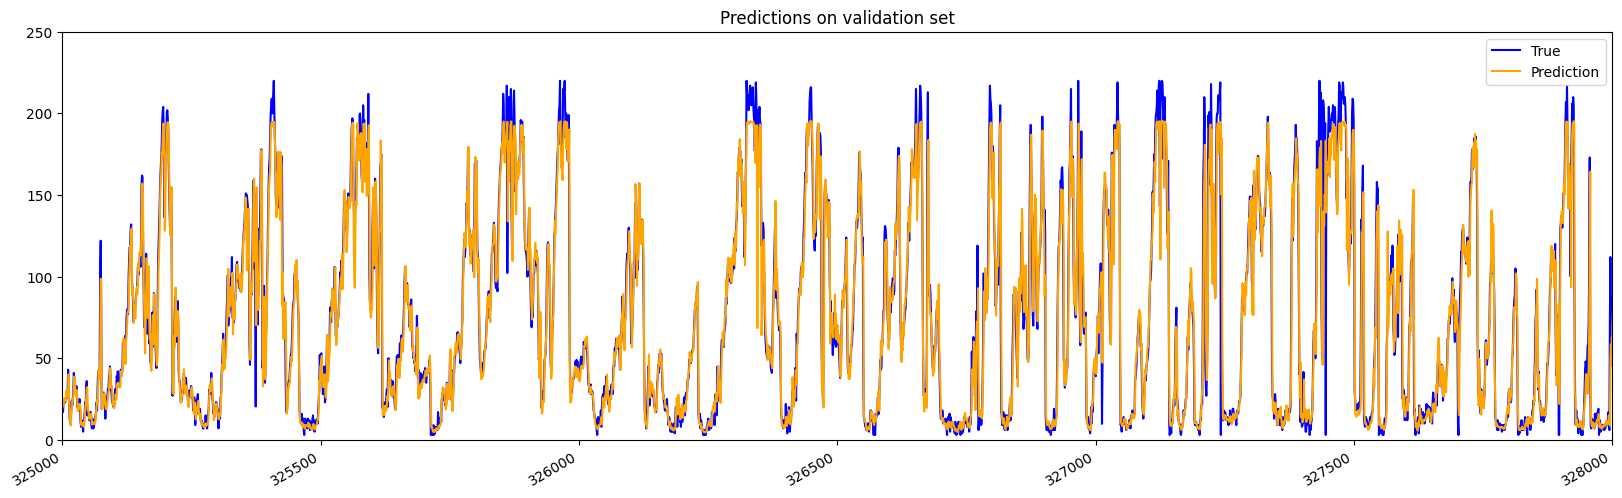

In [90]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(valid.iloc[CFG.seq_length:].index, valid_targets, color='b', label='True')
ax.plot(valid.iloc[CFG.seq_length:].index, valid_predictions, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


ax.axis([325000, 328000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()

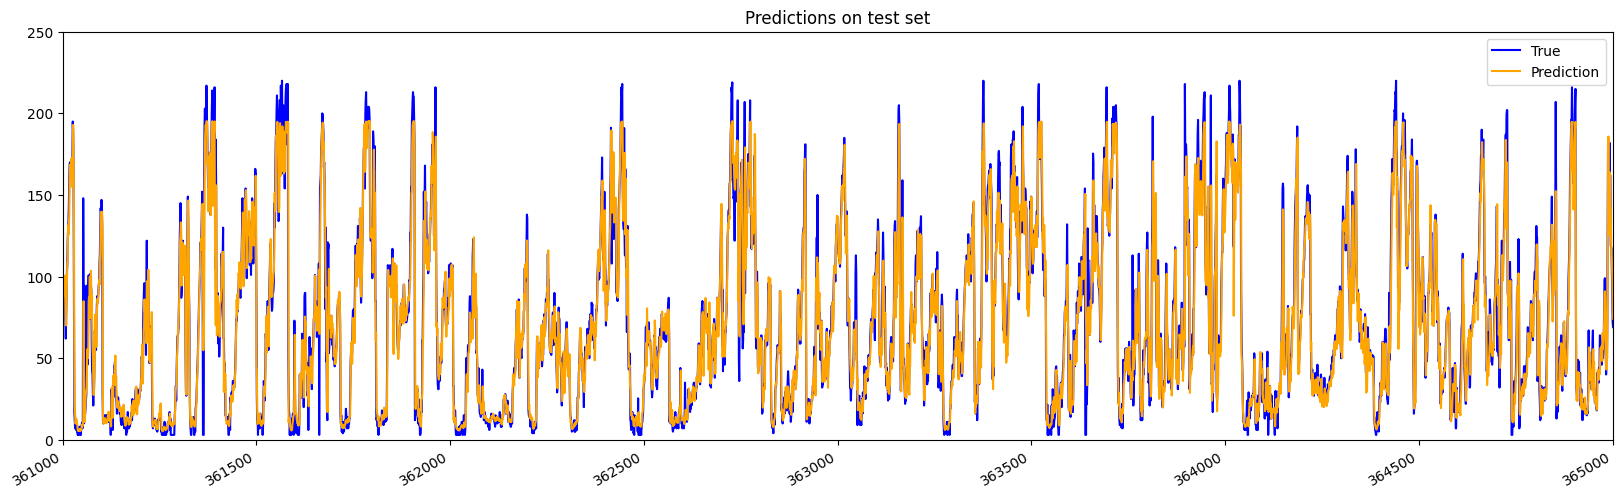

In [91]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test.iloc[CFG.seq_length:].index, test_targets, color='b', label='True')
ax.plot(test.iloc[CFG.seq_length:].index, test_preds, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


ax.axis([361000, 365000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on test set')
plt.show()